## InternVL variants

In [1]:
import copy
import pandas as pd
from datasets import load_dataset
import requests
import numpy as np
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [2]:
path = "Salesforce/cogalign-internvl2_5-mpo-4b"

In [3]:
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().cuda()
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# Taken from InternVL's code
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12, is_url=False):
    if is_url:
        image = Image.open(requests.get(image_file, stream=True).raw)
    else:
        image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [5]:
chocolate = load_dataset("khhuang/CHOCOLATE")["test"]

In [6]:
chocolate_df = pd.DataFrame(chocolate)

In [7]:
chocolate_df_lvlm = chocolate_df.loc[chocolate_df.split=="LVLM",:]
chocolate_df_lvlm.head()

,image_path,labels,split,dataset,model,_id,sentences
1,https://raw.githubusercontent.com/khuangaf/mul...,"[[], [], [label_error], [label_error, value_er...",LVLM,pew,gpt4v,gpt4v-pew_multi_col-3923,[The chart presents data on opinions regarding...
2,https://raw.githubusercontent.com/khuangaf/mul...,"[[], [trend_error], [trend_error], [trend_error]]",LVLM,vistext,gpt4v,gpt4v-vistext_7279,[The chart presents the age structure of Alger...
7,https://raw.githubusercontent.com/khuangaf/mul...,"[[], [label_error], [value_error], [label_erro...",LVLM,vistext,bard,bard-vistext_4816,[The graph shows the number of racially motiva...
11,https://raw.githubusercontent.com/khuangaf/mul...,"[[], [], [], [], [], [], []]",LVLM,pew,gpt4v,gpt4v-pew_multi_col-1032,[The chart presents the feelings of U.S. adult...
14,https://raw.githubusercontent.com/khuangaf/mul...,"[[], [label_error], [], [label_error], [label_...",LVLM,vistext,gpt4v,gpt4v-vistext_964,[The chart presents the data on U.S. steel scr...


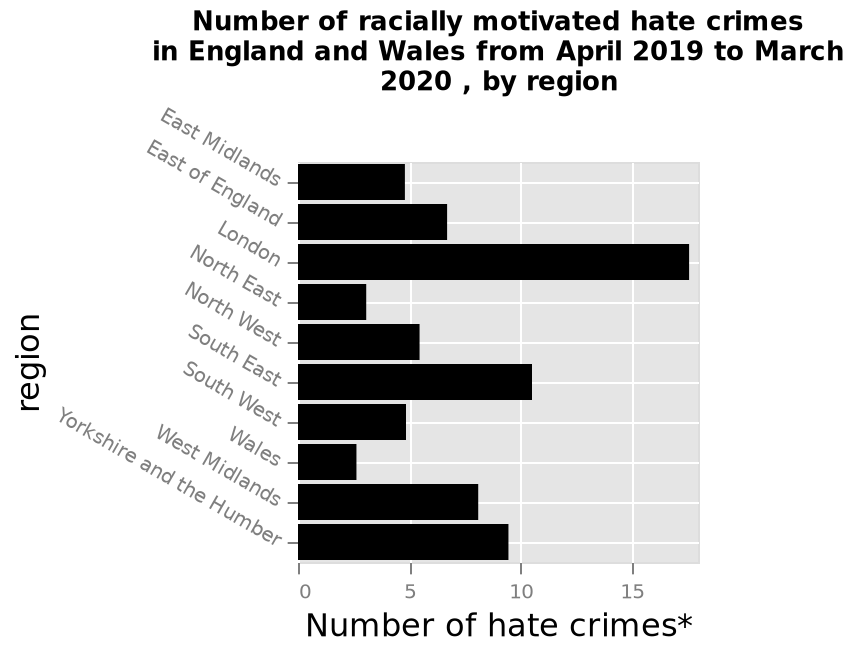

In [8]:
# set the max number of tiles in `max_num`
instance =  chocolate_df_lvlm.iloc[2]
caption = ' '.join(instance.sentences)

url = instance.image_path
pixel_values = load_image(url, max_num=12, is_url=True).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=True)
Image.open(requests.get(url, stream=True).raw)

In [9]:
# single-image single-round conversation
prompt = f"""
You are given a chart and a caption, you are tasked to detect whether the caption is factually
consistent with the chart. A caption is factually consistent with the chart if it describes the datapoints within the charts without factual errors (e.g. wrong label, value, trends).
[Start of Caption]
{caption}
[End of Caption]
For the above caption, you should respond 'Answer: Yes' if it is factually consistent with the chart. Otherwise, respond 'Answer: No'. Do not provide explanation or other thing.
"""
question = f'<image>\n{prompt}'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


User: <image>

You are given a chart and a caption, you are tasked to detect whether the caption is factually
consistent with the chart. A caption is factually consistent with the chart if it describes the datapoints within the charts without factual errors (e.g. wrong label, value, trends).
[Start of Caption]
The graph shows the number of racially motivated hate crimes in England and Wales from April 2019 to March 2020, by region. The regions are listed on the x-axis, and the number of hate crimes is listed on the y-axis. The highest number of racially motivated hate crimes occurred in London, with 15,367 offenses. This was followed by the West Midlands (10,882 offenses), Greater Manchester (8,982 offenses), and Yorkshire and the Humber (8,318 offenses). The lowest number of racially motivated hate crimes occurred in Wales, with 3,171 offenses. There is a clear regional variation in the number of racially motivated hate crimes. The regions with the highest populations also have the hi

## LLaVA-OV variants

In [10]:
# You must install llava-next (https://github.com/LLaVA-VL/LLaVA-NeXT/tree/main)
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

In [ ]:
model_name = "llava_qwen"
tokenizer, llava_model, image_processor, _ = load_pretrained_model(
    "Salesforce/cogalign-llava-ov-0_5b",
    None,
    model_name,
    device_map="cpu",
)
llava_model.cuda()

In [12]:
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images([image], image_processor, llava_model.config)
image_tensor = [_image.to(dtype=torch.float16, device='cuda') for _image in image_tensor]

conv_template = "qwen_1_5"  # Make sure you use correct chat template for different models
question = DEFAULT_IMAGE_TOKEN + f"\n{prompt}"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to('cuda')
image_sizes = [image.size]


cont = llava_model.generate(
    input_ids,
    images=image_tensor,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=4096,
)
response = tokenizer.batch_decode(cont, skip_special_tokens=True)[0]
print(f'User: {question}\nAssistant: {response}')

/export/home/miniconda3/envs/vlmeval/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/export/home/miniconda3/envs/vlmeval/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/export/home/miniconda3/envs/vlmeval/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask is not

User: <image>

You are given a chart and a caption, you are tasked to detect whether the caption is factually
consistent with the chart. A caption is factually consistent with the chart if it describes the datapoints within the charts without factual errors (e.g. wrong label, value, trends).
[Start of Caption]
The graph shows the number of racially motivated hate crimes in England and Wales from April 2019 to March 2020, by region. The regions are listed on the x-axis, and the number of hate crimes is listed on the y-axis. The highest number of racially motivated hate crimes occurred in London, with 15,367 offenses. This was followed by the West Midlands (10,882 offenses), Greater Manchester (8,982 offenses), and Yorkshire and the Humber (8,318 offenses). The lowest number of racially motivated hate crimes occurred in Wales, with 3,171 offenses. There is a clear regional variation in the number of racially motivated hate crimes. The regions with the highest populations also have the hi